# Demonstration: Maximising Persistence

We demonstrate how we can find a spectral wavelet, parametrised by a basis of chebyshev polynomials, such that the total persistence of a graph's filtration is maximised. 

In [1]:
import numpy as np
import networkx as nx

import torch
import torch.optim as optim
import torch.nn as nn

import numpy as np
from scipy.linalg import eigh

import pickle

from models import models
from models import utils
import numpy.polynomial.chebyshev as cheby

import matplotlib.pyplot as plt

## Choosing a Model

We consider a wavelet spanned by a degree 6 chebyshev polynomial, with coefficients normalised to 1. We truncate the barcode to the 25 most persistent intervals as a computational necessity

In [2]:
cheby_degree = 6
max_intervals = 100

## Loading the data


In [61]:
dataset_name = 'COX2'

graph_list = pickle.load(open('data_example/' + dataset_name + '/networkx_graphs.pkl', 'rb'))

print('The ' + dataset_name + ' dataset has ', len(graph_list), ' graphs.')

The COX2 dataset has  467  graphs.


## Preprocess the data

The ChebyshevWavelets pytorch module takes in a list of dictionaries, each dictionary representing the necessary data to compute spectral wavelets.

The dictionary contains the following fields:
- 'chebyshev': an intermediary matrix (num vertices) x (chebyshev degree) for computations; the vertex values of the filtration are given by the product of this matrix with the vector of chebyshev coefficients
- 'simplex_tree': the Gudhi representation of a simplicial complex

In [62]:
data = []
for i in range(len(graph_list)):
    
    G = graph_list[i]
    datum = dict()
    L = nx.normalized_laplacian_matrix(G)
    w, v = eigh(L.todense()) #computes eigenvalues w and eigenvectors
    vandermonde = cheby.chebvander(w.flatten()-1, cheby_degree)
    datum['chebyshev'] = torch.from_numpy(np.matmul(v**2, vandermonde[:, 1:])).float()

    hks = np.matmul(v**2,  np.exp(-0.1*w)).flatten() #random initial filtration for the simplex_tree
    st = utils.simplex_tree_constructor([list(e) for e in G.edges()])
    datum['simplex_tree'] = utils.filtration_update(st, hks)
    data.append(datum)
print('Finished initial processing')
del graph_list


Finished initial processing


## Experiment Design

### Tenfolding

We find a set of chebyshev coefficients that maximise the average $L^2$-persistence of the graph barcodes across the dataset

We perform a ten-fold cross validation. In a ten-fold, we randomly partition the dataset into 10 portions. We perform the maximisation across 9 portions and then validate the learnt parameters on the remaining portion. We cycle through the ten portions so that each portion is the validation set once.

Normally in machine learning practices, we conduct 10 ten-folds and average across all 100 validation measures, but in the interest of time we only perform one ten-fold in this demo.

In [10]:
data_len = len(data)
test_size = data_len // 10
train_size = data_len - test_size

NameError: name 'data' is not defined

### Optimisation using PyTorch tools
We specify the batch size and the number of epochs. We use stochastic gradient descent.

In [14]:
bs = {'COX2': 36, 'MUTAG': 17, 'DHFR': 31}
dl = {'COX2': 467, 'MUTAG': 188, 'DHFR': 756}
batch_size = bs[dataset_name]
data_len = dl[dataset_name]
test_size = data_len // 10
train_size = data_len - test_size
### training parameters #####
#batch_size = 31 #DHFR
#batch_size = 17 #MUTAG
#batch_size = 36 #COX2
#batch_size = 90 #IMDB-BINARY
#batch_size = 137 #NCI1

train_batches = np.ceil((data_len-test_size)/batch_size).astype(int)
max_epoch = 10

print('num points = ', data_len, ' number of batches = ', train_batches, ' batch size = ', batch_size, ' test size ', test_size)

num points =  467  number of batches =  12  batch size =  36  test size  46


In [7]:
p_tracker = []
tt_loss = []
tn_loss = []
torch.manual_seed(99)
rng_state= torch.get_rng_state() #seed init to ensure same initial conditions for each training

for split in range(10):
    
    np.random.seed(split)
    shuffidx = list(range(data_len)) # data indexer
    np.random.shuffle(shuffidx)

    ####### torch random seeds #######

    for fold in range(10):
        print ('> fold ', fold)

        param_tracker = []
        test_loss = []
        train_loss = []

        test_bottom = fold * test_size
        test_top = (1+fold) * test_size
        test_indices = shuffidx[test_bottom : test_top]
        train_indices = shuffidx[0:test_bottom] + shuffidx[test_top :]

        torch.set_rng_state(rng_state) #fix init state
        barcodes = models.ChebyshevWavelets(cheby_degree = cheby_degree, max_intervals = max_intervals)
        param_tracker.append(list(barcodes.cheby_params.detach().flatten().numpy()))

        optimizer = optim.SGD(barcodes.parameters(), lr=1e-3, weight_decay = 0.0)

        for epoch in range(max_epoch):

            barcodes.train()
            #np.random.shuffle(train_indices)
            for b in range(train_batches):

                train_indices_batch = train_indices[b*batch_size : (b+1)*batch_size ]
                optimizer.zero_grad()
                births, deaths = barcodes([data[i] for i in train_indices])
                loss = -torch.sum((deaths - births)**2)/train_size
                loss.backward()

                optimizer.step()

            barcodes.eval()
            param_tracker.append(list(barcodes.cheby_params.detach().flatten().numpy()))


            barcodes.eval()
            b,d = barcodes([data[i] for i in train_indices])
            tnl = torch.sum((d- b)**2)/train_size
            b,d  = barcodes([data[i] for i in test_indices])
            ttl = torch.sum((d- b)**2)/test_size
            test_loss.append(ttl.detach().numpy())
            train_loss.append(tnl.detach().numpy())

            if epoch == max_epoch:
                print(epoch, param_tracker[-1])
                print('train: ', train_loss[-1])
                print('test: ',test_loss[-1])

        p_tracker.append(param_tracker)
        tt_loss.append(test_loss)
        tn_loss.append(train_loss)

> fold  0
> fold  1
> fold  2
> fold  3
> fold  4
> fold  5
> fold  6
> fold  7
> fold  8
> fold  9
> fold  0


KeyboardInterrupt: 

In [8]:
tt_loss = np.array(tt_loss)
tn_loss = np.array(tn_loss)

In [9]:
np.shape(train_errors)

NameError: name 'train_errors' is not defined

In [10]:
plt.plot(train_errors[1]  - train_errors[0])

NameError: name 'train_errors' is not defined

In [11]:
mean_test = np.mean(tt_loss, axis=0)
std_test = np.std(tt_loss, axis=0)

mean_train =np.mean(tn_loss, axis=0)
std_train = np.std(tn_loss, axis=0)


In [3]:
dataset_name = 'COX2'
tt_loss, tn_loss = pickle.load(open(dataset_name + '_tp2.pkl', 'rb'))

In [4]:
tt_loss = np.array(tt_loss)
tn_loss = np.array(tn_loss)

median_test = np.median(tt_loss, axis=0)
median_train =np.median(tn_loss, axis=0)


In [5]:
test_errors = np.abs(np.quantile(tt_loss, [0.05, 0.95], axis =0) - median_test)
train_errors = np.abs(np.quantile(tn_loss, [0.05, 0.95], axis =0) - median_train)

In [6]:
np.shape(median_test)

(10,)

In [7]:
plt.rcParams.update({'font.size': 18})

We see that the optimisation has converged to a local optimum and the test 

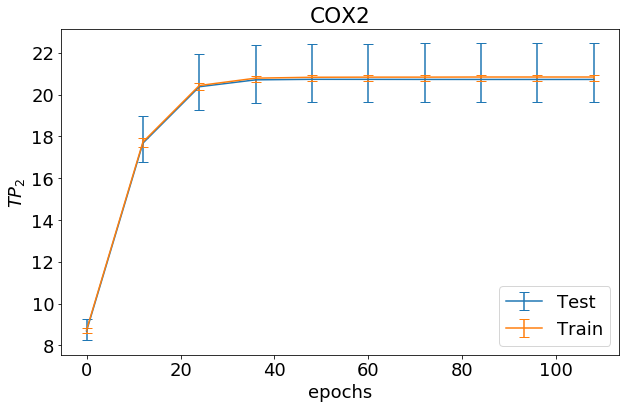

In [17]:
#plt.plot(mean_test, label = 'test mean')
#plt.plot(mean_train, label = 'train mean')

plt.figure(figsize = [10, 6])
plt.xlabel('epochs')
plt.ylabel(r'$TP_2$')
plt.title('COX2')
x = np.linspace(0, (len(median_test)-1)*train_batches, len(median_test))

plt.errorbar(x, median_test, yerr = test_errors, color = 'tab:blue', label = 'Test', capsize = 5)
plt.errorbar(x, median_train, yerr = train_errors, color ='tab:orange', label = 'Train', capsize = 5)

#for i in range(100):
#    plt.plot(tt_loss[i], '.', color = 'tab:blue')
#    plt.plot(tn_loss[i], '.', color = 'tab:orange')
plt.legend(loc = 4)
#plt.savefig(dataset_name + '.pdf', dpi = 300)

In [18]:
tt_loss_cox2, tn_loss_cox2 = pickle.load(open('COX2_tp2.pkl', 'rb'))
tt_loss_mutag, tn_loss_mutag = pickle.load(open('MUTAG_tp2.pkl', 'rb'))

In [19]:
tt_loss_cox2 = np.array(tt_loss_cox2)
tn_loss_cox2 = np.array(tn_loss_cox2)

median_test_cox2 = np.median(tt_loss_cox2, axis=0)
median_train_cox2 =np.median(tn_loss_cox2, axis=0)


tt_loss_mutag = np.array(tt_loss_mutag)
tn_loss_mutag = np.array(tn_loss_mutag)

median_test_mutag = np.median(tt_loss_mutag, axis=0)
median_train_mutag =np.median(tn_loss_mutag, axis=0)

In [20]:
test_errors_cox2 = np.abs(np.quantile(tt_loss_cox2, [0.05, 0.95], axis =0) - median_test_cox2)
train_errors_cox2 = np.abs(np.quantile(tn_loss_cox2, [0.05, 0.95], axis =0) - median_train_cox2)
test_errors_mutag = np.abs(np.quantile(tt_loss_mutag, [0.05, 0.95], axis =0) - median_test_mutag)
train_errors_mutag = np.abs(np.quantile(tn_loss_mutag, [0.05, 0.95], axis =0) - median_train_mutag)


In [40]:
plt.rcParams.update({'font.size': 18})

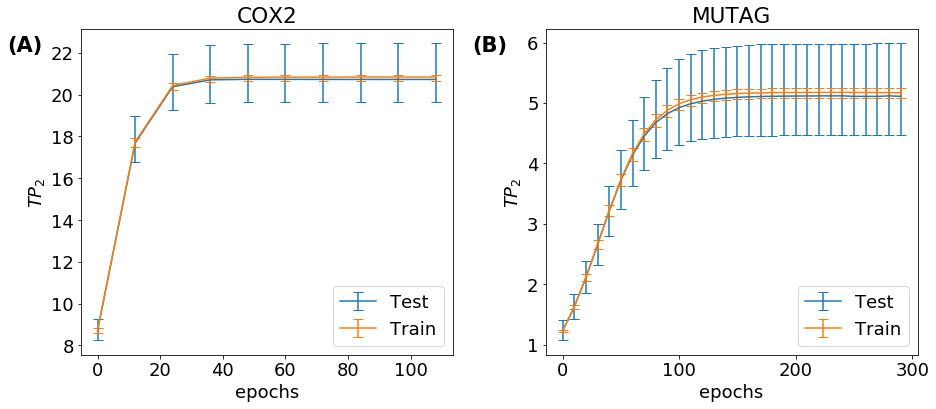

In [80]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = [15, 6])
#fig.suptitle(r'Maximising $TP_2$')


train_batches = np.ceil((dl['MUTAG']-dl['MUTAG']//10)/bs['MUTAG']).astype(int)
x = np.linspace(0, (len(median_test_mutag)-1)*train_batches, len(median_test_mutag))

ax2.errorbar(x, median_test_mutag, yerr = test_errors_mutag, color = 'tab:blue', label = 'Test', capsize = 5)
ax2.errorbar(x, median_train_mutag, yerr = train_errors_mutag, color ='tab:orange', label = 'Train', capsize = 5)

ax2.set_xlabel('epochs')
ax2.set_ylabel(r'$TP_2$')
ax2.set_title('MUTAG')
ax1.text(-0.15, 0.95, '(B)', horizontalalignment='center',verticalalignment='center' , fontsize=21, weight = 'bold', transform=ax2.transAxes)
ax2.legend(loc = 4)

train_batches = np.ceil((dl['COX2']-dl['COX2']//10)/bs['COX2']).astype(int)
x = np.linspace(0, (len(median_test_cox2)-1)*train_batches, len(median_test_cox2))
ax1.errorbar(x, median_test_cox2, yerr = test_errors_cox2, color = 'tab:blue', label = 'Test', capsize = 5)
ax1.errorbar(x, median_train_cox2, yerr = train_errors_cox2, color ='tab:orange', label = 'Train', capsize = 5)

ax1.set_xlabel('epochs')
ax1.set_ylabel(r'$TP_2$')
ax1.set_title('COX2')
ax1.legend(loc = 4)
ax1.text(-0.15, 0.95, '(A)', horizontalalignment='center',verticalalignment='center' , fontsize=21, weight = 'bold', transform=ax1.transAxes)


#fig.tight_layout()

fig.subplots_adjust(wspace = 0.25)
plt.savefig('cox2_and_mutag_tp2.pdf', dpi = 300)